# Project: Adversarial BayesFlow

In [1]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import tensorflow as tf
import tensorflow_probability as tfp

sys.path.append(os.path.abspath(os.path.join('../BayesFlow')))

from bayesflow.trainers import ParameterEstimationTrainer
from bayesflow.networks import InvertibleNetwork, InvariantNetwork
from bayesflow.amortizers import SingleModelAmortizer
from bayesflow.models import GenerativeModel
from bayesflow.diagnostics import true_vs_estimated
from bayesflow.exceptions import ConfigurationError

from meta_aux_classes import *

In [2]:
class GaussianPrior:
    def __init__(self, D, mu_mean=0, mu_scale=1):
        self.D = D
        self.mu_mean = mu_mean
        self.mu_scale = mu_scale
    
    def __call__(self, n_sim):
        theta = np.random.default_rng().normal(self.mu_mean, self.mu_scale, size=(n_sim, self.D))
        return theta

class GaussianSimulator:
    def __init__(self, D, s = None):
        
        # Default: Unit variance
        if s is None:
            sigma = np.eye(D)
            
        # Unit variance with factor s
        elif isinstance(s, (int, float)):
            sigma = np.eye(D) * s
            
            
        # s is list or np.array --> Either custom diagonal or full
        elif isinstance(s, (list, np.ndarray)):
            # cast any list-like input to float np.array 
            if isinstance(s, list):
                s = np.array(s)   
            s = s.astype(float)
            
            # Diagonal covariance matrix with different diagonal entries (from s)
            if s.ndim == 1:
                assert len(s) == D, "Must provide D entries in diagonal s!"
                sigma = np.diag(s)
                
            # Full covariance matrix    
            elif s.ndim == 2:
                assert s.shape[0] == D and s.shape[1] == D, "Must provide DxD matrix!"
                try: 
                    _ = np.linalg.cholesky(s)
                except:
                    raise ConfigurationError("Covariance Matrix must be positive semidefinite!")
                
                sigma = s
            
        self.D = D    
        self.sigma = sigma
    
    def __call__(self, theta, n_obs):
        n_sim, D = theta.shape
        assert D == self.D
        
        tril = tf.linalg.cholesky(np.stack([self.sigma] * n_sim))   # tf requires cholesky decomposed sigma
        
        mvn = tfp.distributions.MultivariateNormalTriL(loc=theta, scale_tril=tril)

        sim_data = mvn.sample(n_obs)
        sim_data = np.array(sim_data)
        sim_data = np.transpose(sim_data, (1, 0, 2))
        return sim_data
    
D = 3
prior = GaussianPrior(D=D)
simulator = GaussianSimulator(D=D)

In [ ]:
D = 3
prior = GaussianPrior(D=D)
simulator = GaussianSimulator(D=D, s = 2.5)

theta = prior(4)
print(simulator.sigma)
simulator(theta, 5)

In [ ]:
D = 3
prior = GaussianPrior(D=D)
simulator = GaussianSimulator(D=D, s = [1,2,3])

theta = prior(4)
print(simulator.sigma)
simulator(theta, 5)

In [ ]:
D = 3
prior = GaussianPrior(D=D)
simulator = GaussianSimulator(D=D, s = np.array([1,2,3]))

theta = prior(4)
print(simulator.sigma)
simulator(theta, 5)

In [ ]:
D = 3
prior = GaussianPrior(D=D)
simulator = GaussianSimulator(D=D, s = np.array([[1,0,0],[0,1,0],[0,0,1]]))

theta = prior(4)
print(simulator.sigma)
simulator(theta, 5)

# (1) Define minimalistic BayesFlow
**Task:** Learn means of a 5-variate Gaussian with unit variance.

In [3]:
D = 5 

#########

prior = GaussianPrior(D=D)
simulator = GaussianSimulator(D=D)
generative_model = GenerativeModel(prior, simulator)

#########

summary_meta = {
    'n_dense_s1': 2,
    'n_dense_s2': 2,
    'n_dense_s3': 2,
    'n_equiv':    1,
    'dense_s1_args': {'activation': 'relu', 'units': 32},
    'dense_s2_args': {'activation': 'relu', 'units': 32},
    'dense_s3_args': {'activation': 'relu', 'units': 32},
}

class BottleneckSummaryNet(tf.keras.Model):
    def __init__(self, inv_meta={}, n_out=10, activation_out=None):
        super(BottleneckSummaryNet, self).__init__()

        self.invariant_net = InvariantNetwork(inv_meta)
        self.out_layer = tf.keras.layers.Dense(n_out, activation=activation_out)
    
    def __call__(self, x):
        out_inv = self.invariant_net(x)
        out = self.out_layer(out_inv)
        return out


summary_net = BottleneckSummaryNet(inv_meta=summary_meta, 
                                   n_out=D*2,  # one mean and variance per dim
                                   activation_out=None  # linear
                                  )


inference_meta = {
    'n_coupling_layers': 2,
    's_args': {
        'units': [32, 32, 32],
        'activation': 'elu',
        'initializer': 'glorot_uniform',
    },
    't_args': {
        'units': [32, 32, 32],
        'activation': 'elu',
        'initializer': 'glorot_uniform',
    },
    'n_params': D,
    'alpha': 1.9,
    'permute': True
}

inference_net = InvertibleNetwork(inference_meta)

amortizer = SingleModelAmortizer(inference_net, summary_net)

In [4]:
trainer = ParameterEstimationTrainer(amortizer,
                      generative_model,
                      learning_rate=0.0001,
                      checkpoint_path='export_ckpt/'
                     )

Networks loaded from export_ckpt/ckpt-101


# (2) Converge BayesFlow network

In [ ]:
losses = trainer.train_rounds(epochs=10, rounds=5, sim_per_round=20000, batch_size=1024, n_obs=100)

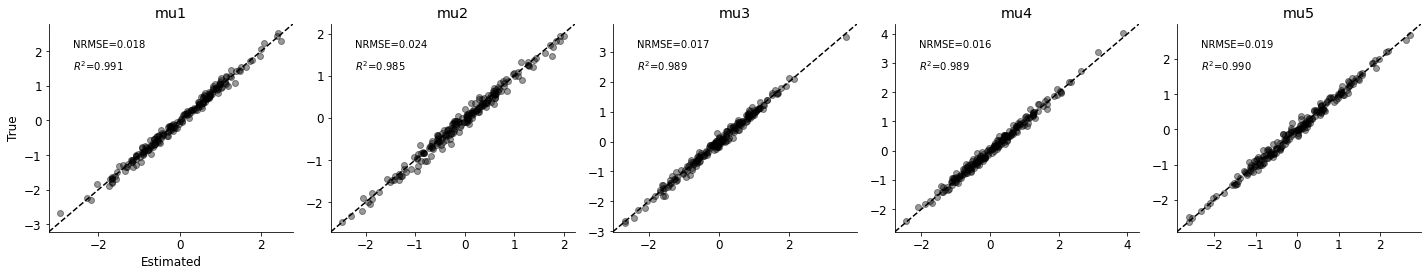

In [5]:
# Validate (quick and dirty)
p, x = trainer._forward_inference(200, 100)
param_samples = trainer.network.sample(x, n_samples=200)
param_means = param_samples.mean(axis=0)
true_vs_estimated(p, param_means, ['mu{}'.format(i) for i in range(1, 5+1)], figsize=(20,4))

In [12]:
s = trainer.network.summary_net(x)
s = np.array(s)

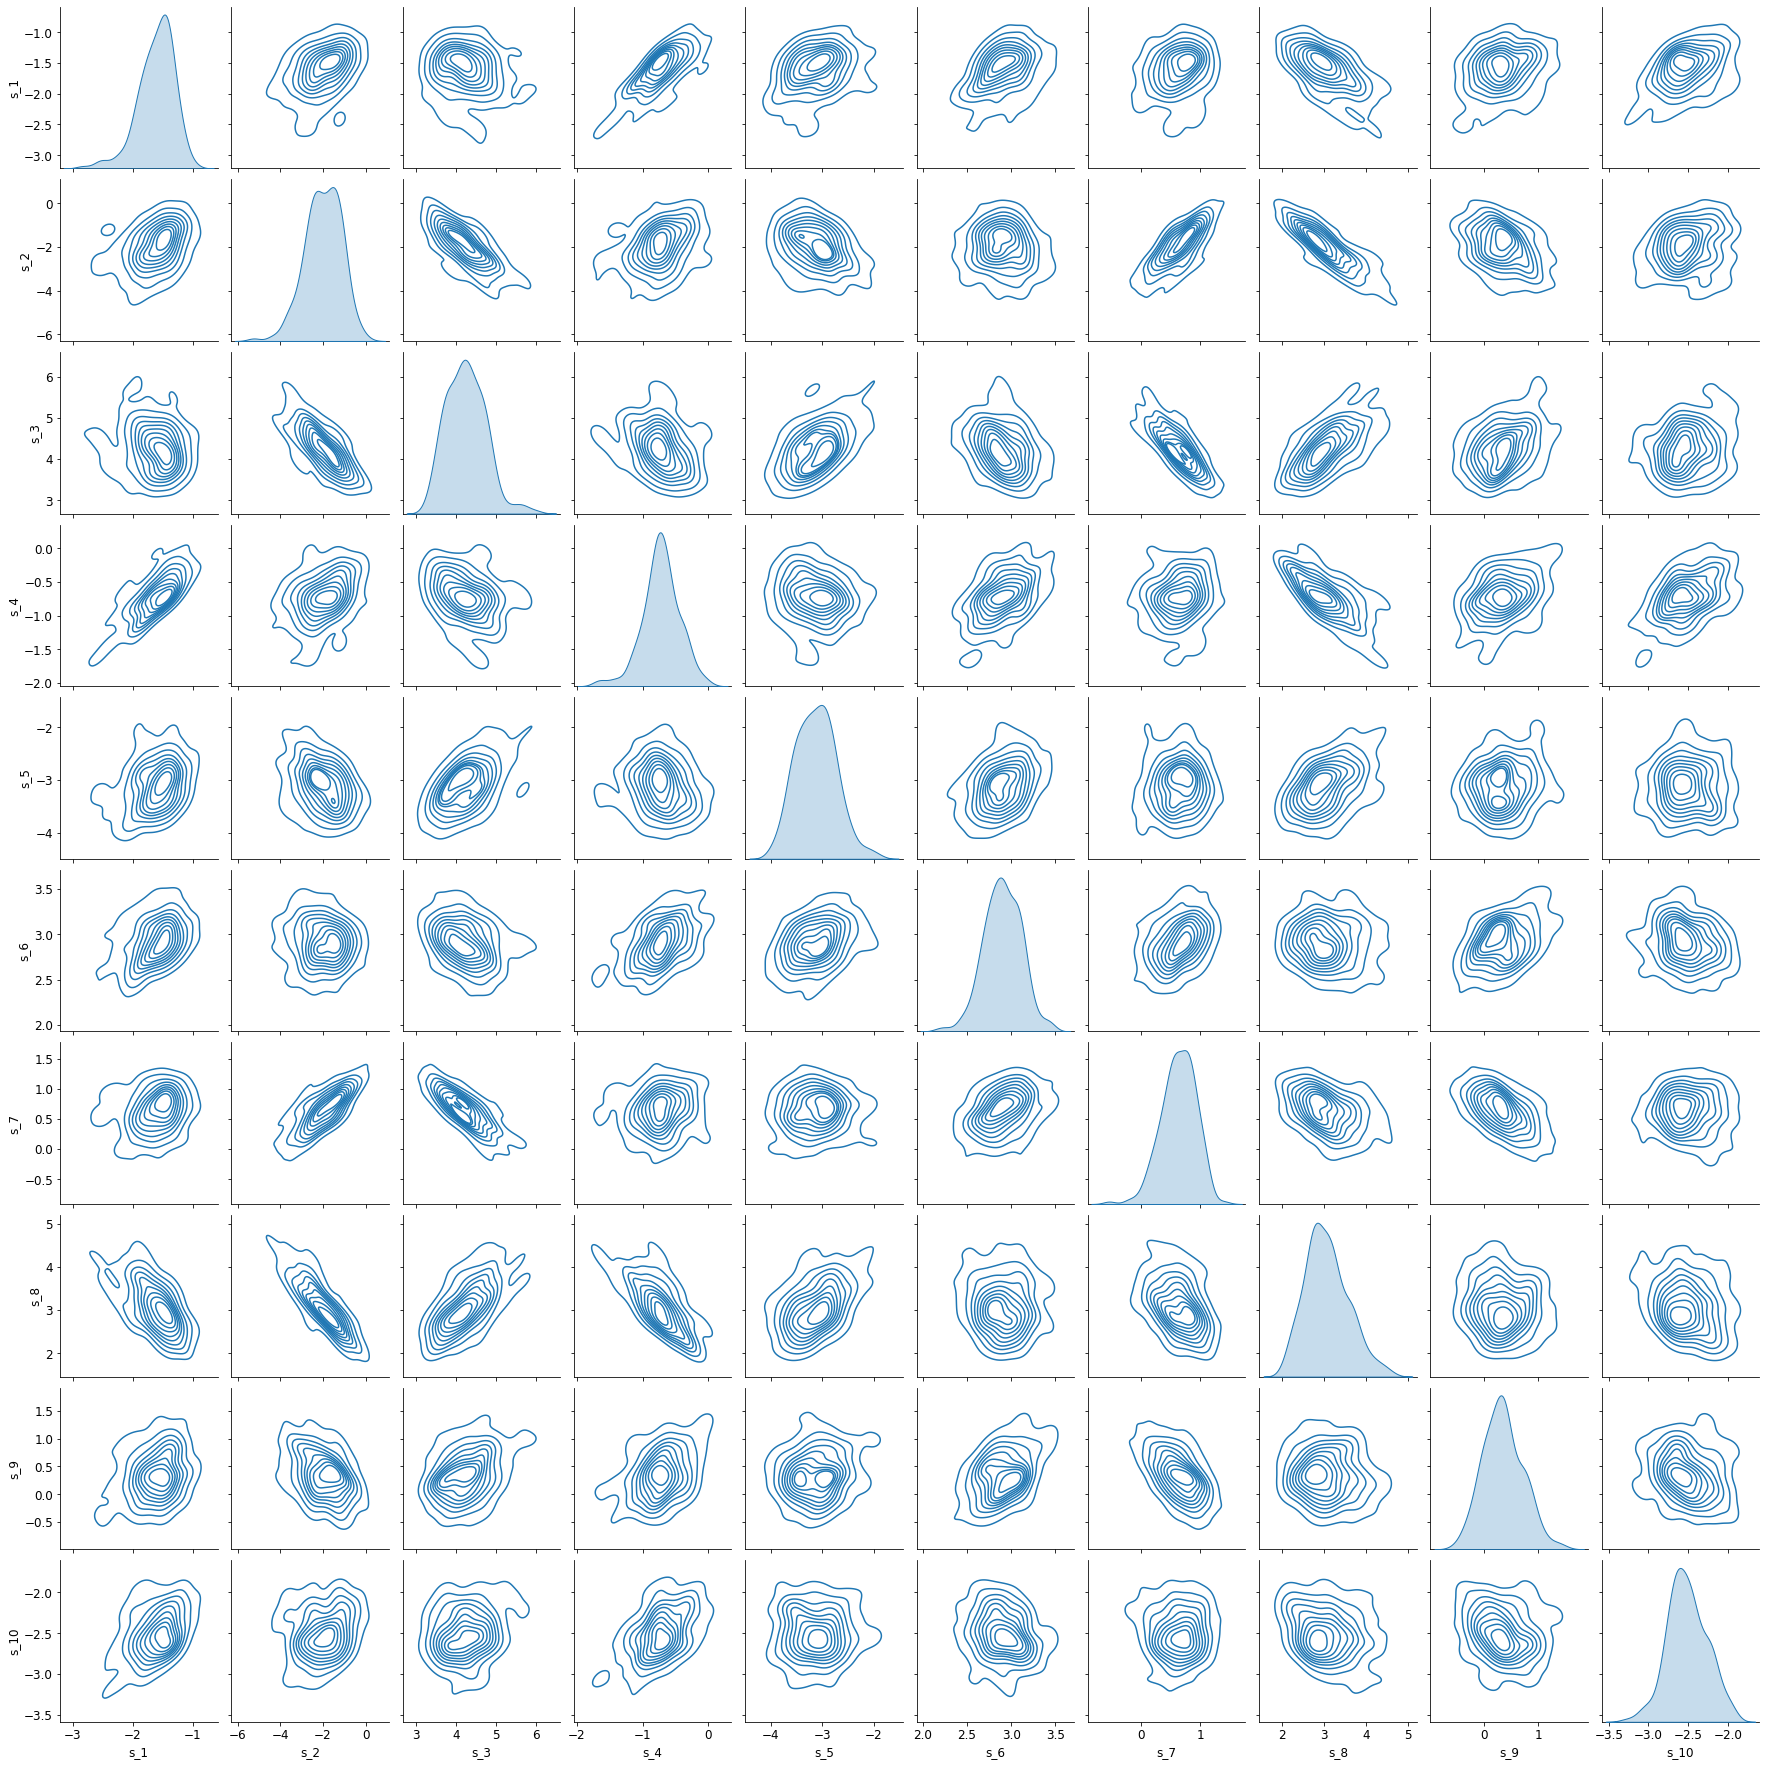

In [13]:
sns.pairplot(pd.DataFrame(s, columns=['s_{}'.format(i) for i in range(1, s.shape[1]+1)]), kind="kde")

# (3) Adversarial Tasks

## (A1) Wrong Prior

## (A2) Wrong parameterization of fixed parameters (correct Likelihood)

## (A3) Wrong Likelihood

## (A4) Contamination
$\mathbf{x}_n = \mathbf{x}_n + \xi$